### Test case LVV-T1838: Verify calculation of image fraction affected by ghosts

Verify that the DM system provides code to assess whether the percentage of image area that has ghosts with surface brightness gradient amplitude of more than 1/3 of the sky noise over 1 arcsec is less than **GhostAF = 1 percent**.

*Discussion*: We will use the `compare_warp_artifact_mask` datasets, which record the masked pixels after the artifact rejection step has been run. These masks are created in the process of making deep coadds, wherein the set of overlapping warped visits are compared to each other to identify anomalies that appear only in a single visit. These are masked as CLIPPED and not included in the coadds.

Note: artifact rejection simply removes any anomalous pixels. It thus does not explicitly address the portion of the requirement concerning the surface brightness gradient amplitude, and it also removes pixels that are anomalous for other reasons besides ghosts (e.g., asteroid streaks). Nonetheless, this test likely represents an upper limit on the number of pixels affected by ghosts.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay

In [2]:
butler = Butler('/repo/embargo', collections="LSSTCam/runs/DRP/20250604_20250814/w_2025_33/DM-52202")

#### Query the butler for artifact masks

Extract a list of datasetRefs for `compare_warp_artifact_mask` datasets.

In [3]:
amask_refs = butler.query_datasets('compare_warp_artifact_mask',
                                   collections="LSSTCam/runs/DRP/20250604_20250814/w_2025_33/DM-52202",
                                   limit=None)

In [4]:
len(amask_refs)

834983

#### Extract stats from a subset of images

Randomly select a large number (5000) images, extracting the counts of pixels masked with each of the various mask bits. Extract for each image the number of pixels containing data (i.e., that aren't masked with NO_DATA), then calculate the fraction of pixels with data that were masked as CLIPPED.

In [5]:
clipped_stats = []
nclipped = []
npix_with_data = []

nsamples = 5000
random_indices = np.random.randint(0, len(amask_refs), nsamples)

for ind in random_indices:
    amask = butler.get(amask_refs[ind])
    mask_count_dict = {}

    for key in amask.getMaskPlaneDict().keys():
        mask_count_dict[key] = 0

    values, counts = np.unique(amask.array, return_counts=True)
    for value, count in zip(values, counts):
        # print(value, '('+str(count)+')', amask.interpret(value))
        if value > 0:
            for plane in str.split(amask.interpret(value), ','):
                mask_count_dict[plane] += count

    npix = (np.size(amask.array)-mask_count_dict['NO_DATA'])
    clipped_stats.append(mask_count_dict['CLIPPED']/npix)
    nclipped.append(mask_count_dict['CLIPPED'])
    npix_with_data.append(npix)

tab = Table([npix_with_data, nclipped, clipped_stats], names=['n_ok_pix', 'nclipped', 'clip_pct'])

/tmp/ipykernel_43350/3353062304.py:23: RuntimeWarning: invalid value encountered in scalar divide
  clipped_stats.append(mask_count_dict['CLIPPED']/npix)


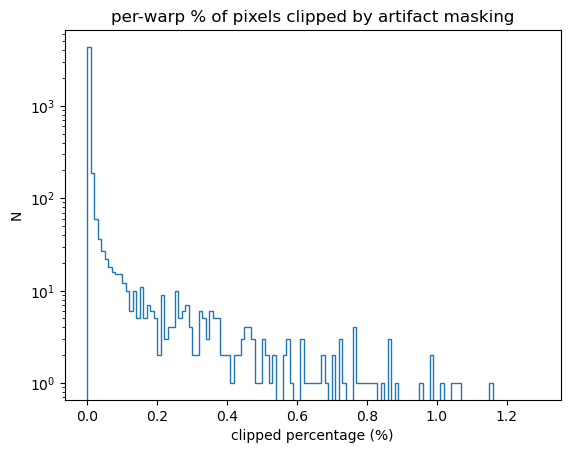

In [6]:
plt.hist(tab['clip_pct'], bins=np.arange(0, 1.3, 0.01), histtype='step')
plt.yscale('log')
plt.title('per-warp % of pixels clipped by artifact masking')
plt.ylabel('N')
plt.xlabel('clipped percentage (%)')
plt.show()

## Results

We see that the vast majority of the images that were checked have clipped percentages less than 0.2%, and that all but a small handful of the 5000 images have clipped percentages <1.0%. Given that these percentages are likely upper limits on the fraction of pixels affected by ghosts, we deem this test a **Pass*.